## Try: Replicate (much of) a Publication With PalmettoBUG

Paper: https://doi.org/10.1016/j.cmet.2018.11.014 
("A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry". Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5.)

Data source:

Download (images, metadata -- likely update all to version 2 before finalizing!): https://data.mendeley.com/datasets/cydmwsfztj/1

Download (masks, panel, 100 images subset): https://data.mendeley.com/datasets/cydmwsfztj/2     (version 2)

Data License: CC-BY 4.0 ( https://creativecommons.org/licenses/by/4.0/ ). Obviously the data was modified by its preparation for analysis & the analysis itself in PalmettoBUG.

The data requires some shaping / renaming and placing into folders to get them ready for analysis by PalmettoBUG

Notes:

    -- I am currently not working with the entirety of the dataset, only a subset.

    -- The example data's panel / metadata is not set up in a PalmettoBUG-friendly way, so I will need to set that up

    -- This publication does things that are difficult or at currently impossible in PalmettoBUG's GUI
    
        - ex: pseudo-time analysis (not possible in GUI), bounding boxes on individual pancreatic islets (difficult), cell densities
    
    -- I plan on doing this inside jupyter-lab notebooks, which will make some of the impossible steps possible and also precise replication of the steps that I take. However, I will also plan to test certain steps in the GUI to ensure that it is working as well

    -- I am not familiar with diabetes research, I will copy useful biological information from paper's text and methods here: 
           - Beta-cell markers = INS, PIN, IAPP, PTPRN ('markers' ), and PDX1, NKX6-1 ('transcription factors')

           - cell typing markers (use all mentioned in FlowSOM classification method):
                - islet vs. immune vs. exocrine vs. other --> CD99, SYP, AMY2A, KRT19, CD44, CD45, CDH, CD3, CD4, CD8, CD20, MPO, CD68, SMA

                - islet cell subtypes (alpha, beta, gamma, delta) --> INS, PIN, GCG, SST, PPY, PDX1, NKX6-1, IAPP, PCKS2, CD99, SYP

                - immune cells:
                     effector CD8 T cells: 'Tc' -- CD3, CD8, (CD45RA negative)
                     naive CD8 T cells: 'naive Tc' -- CD3, CD8, CD45RA
                     CD4 T cells: 'Th' -- CD3, CD4
                     B cells -- CD20
                     monocytes and macrophages: 'Mphi' -- CD45, CD68
                     neutrophils: 'Neutr' -- MPO
                     'other': CD45 or CD45RA but not in the categories above

                 - exocrine (acinar, ductal) --> KRT19, AMY2A, CD44, CDH

                 - other (endothelial, stroma, unknown) --> SMA, CD31, CD68, CDH

            - islet / blood vessel segmenation markers: SYP, CD99, CD31, CD45, AMY2A, KRT19, Iridum intercalator
                 

In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
start_timer = time.time()

import palmettobug
print(time.time() - start_timer)  ## keep track of time after each major step

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.
64.67516088485718


In [30]:
directory = "C:/Users/Default/Desktop/data/PBUG"  # where I placed the source images (in directory/raw), and the masks in (directory/masks/Masks),
                                                  # as well as the original panel and metadata

In [40]:
downloaded_panel = pd.read_csv(directory + "/original_panel.csv")
downloaded_panel                   ## notice the duplicate of Yb176 -- I not sure what this means. I will need to be careful to ensure that the 
                                   # channel order is the same and the channel labels are accurate (!!)

,TubeNb,MetalTag,Target,Clone,Stock.Conc,Final.Conc,channel,full,main,ilastik_cells,ilastik_structures,clean_Target,shortname,miCAT2,miCAT
0,1056.0,In113,Histone H3,D1H2,300.0,4.00,1.0,1,1,1,1,H3,H3,Cell_HistoneH3,Cell_Histone_1261919In113In113Di_In113
1,1081.0,In115,SMA,1A4,300.0,1.00,2.0,1,1,1,1,SMA,SMA,Cell_SMA,Cell_SMA_1741944In115In115Di_In115
2,NaN,Xe134,Xenon,NaN,NaN,NaN,NaN,0,0,0,0,Xenon,Xenon,NaN,Cell_134XeXe134Di_Xe134
3,1150.0,Pr141,insulin,C27C9,300.0,5.00,3.0,1,1,0,0,INS,INS,Cell_Ins,Cell_insulin_6772013Pr141Pr141Di_Pr141
4,1105.0,Nd142,CD38,EPR4106,300.0,5.00,4.0,1,1,0,0,CD38,CD38,Cell_CD38,Cell_CD38_17191968Nd142Nd142Di_Nd142
5,1125.0,Nd143,CD44,IM7,200.0,1.50,5.0,1,1,1,0,CD44,CD44,Cell_CD44,Cell_CD44_681988Nd143Nd143Di_Nd143
6,1132.0,Nd144,Prohormone Convertase 2,Polyclonal _ PC2,200.0,5.00,6.0,1,1,0,0,PCSK2,PCSK2,Cell_PC2,Cell_Prohorm_17681995Nd144Nd144Di_Nd144
7,1120.0,Nd145,CD99,HCD99,200.0,0.25,7.0,1,1,1,1,CD99,CD99,Cell_CD99,Cell_CD99_8191983Nd145Nd145Di_Nd145
8,987.0,Nd146,CD68,KP1,300.0,5.00,8.0,1,1,0,0,CD68,CD68,Cell_CD68,Cell_CD68_771781Nd146Nd146Di_Nd146
9,1165.0,Sm147,Myeloperoxidase MPO,Polyclonal MPO,300.0,2.50,9.0,1,1,1,0,MPO,MPO,Cell_MPO,Cell_Myelope_2762028Sm147Sm147Di_Sm147


In [41]:
downloaded_panel = downloaded_panel.loc[np.array(downloaded_panel['full']).astype('bool'),['Target','MetalTag','clean_Target']]

downloaded_panel = downloaded_panel[downloaded_panel['clean_Target'] != 'cPARP1']   ## just drop one, ignore the other channel, too

pbug_panel = pd.DataFrame()
pbug_panel['channel'] = list(downloaded_panel['MetalTag'])
pbug_panel['name'] = list(downloaded_panel['clean_Target'])
pbug_panel['keep'] = 1
pbug_panel['segmentation'] = ''    ## I plan to use the masks provided by the paper, not those generated in pbug / iSD by deepcell (or otherwise)
                                   ## so I can ignore this column entirely. Otherwise I'd set channels 0,36,37 to nuclei. I am less certain about the cytoplasmic channel(s)

In [43]:
## uncomment line below to examine panel

pbug_panel

,channel,name,keep,segmentation
0,In113,H3,1,
1,In115,SMA,1,
2,Pr141,INS,1,
3,Nd142,CD38,1,
4,Nd143,CD44,1,
5,Nd144,PCSK2,1,
6,Nd145,CD99,1,
7,Nd146,CD68,1,
8,Sm147,MPO,1,
9,Nd148,SLC2A1,1,


In [44]:
pbug_panel.to_csv(directory + "/panel.csv", index = False)

In [45]:
resolutions = [1.0, 1.0]
ImageAnalysis = palmettobug.imc_entrypoint(directory, resolutions = resolutions, from_mcds = False)
print(time.time() - start_timer)  ## keep track of time after each major step

16389.471710205078


In [32]:
# "convert" raw --> .ome.tiffs. Since were starting with tiffs, this is really just hot-pixel filtering
ImageAnalysis.raw_to_img(hpf = 0.85)

In [ ]:
print(time.time() - start_timer)  ## keep track of time after each major step

In [5]:
## do region measurements

analysis_folder = "analysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/img"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks"
## masks provided in download do not match the PalmettoBUG / Steinbock convention of having identical names to the source files
for i in os.listdir(input_masks):
    current = f'{input_masks}/{i}'
    os.rename(current, current.replace("_masks",""))

#ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = True)

In [47]:
## for 100 image subset -- do segmentation measurements

analysis_folder = "analysis_subset"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/ImageSubset"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks"
## masks provided in download do not match the PalmettoBUG / Steinbock convention of having identical names to the source files
for i in os.listdir(input_images):
    current = f'{input_images}/{i}'
    os.rename(current, current.replace("_clean",""))

ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = False)

All images have intensity and region files written! Did you intend to redo these measurements?


In [48]:
print(time.time() - start_timer)  ## keep track of time after each major step

16413.034578084946


In [50]:
panel, metadata, panel_path, metadata_path = ImageAnalysis.to_analysis()

In [9]:
## read supplied metadata
downloaded_metadata = pd.read_csv(directory + "/Metadata.csv")

## reshape data from the paper to match PalmettoBUG expectations by mering with the auto-generated metdata file:
metadata['image'] = metadata['file_name'].str.replace("_a0_full.fcs","")
new_metadata = metadata.merge(downloaded_metadata, on = "image")
new_metadata['patient_id'] = new_metadata['part']
new_metadata['condition'] = new_metadata['stage']
metadata = new_metadata[['file_name','sample_id','patient_id','condition']]
metadata

,file_name,sample_id,patient_id,condition
0,E02_a0_full.fcs,0,Tail,Non-diabetic
1,E03_a0_full.fcs,1,Tail,Non-diabetic
2,E04_a0_full.fcs,2,Tail,Non-diabetic
3,E05_a0_full.fcs,3,Tail,Non-diabetic
4,E06_a0_full.fcs,4,Tail,Non-diabetic
...,...,...,...,...
95,J30_a0_full.fcs,95,Tail,Long-duration
96,J31_a0_full.fcs,96,Tail,Long-duration
97,J32_a0_full.fcs,97,Tail,Long-duration
98,J33_a0_full.fcs,98,Tail,Long-duration


In [51]:
# assign type / state / none to each marker in the panel
#display(panel)


# none channels are effectively ignored in most steps of PalmettoBUG analysis -- 
# 'none' for segmentation markers
none_channels = ['H3','Ir191','Ir193']  
# 'state' channels not used in the assignemnt of cell types (also these overlap with channels seemingly entirely ignored by the analysis
# I will likely similarly ignore these markers
state_channels = ['pRB','pH3','FOXP3','CD38','CA9','KI-67']

 ## type markers if mentioned in the paper as contributing to their classifier used to group cell types, or mentioned for pseudotime (SLC2A1)
type_channels = ['SMA','INS', 'CD99','CD3e','CD4','CD8a',
                 'SYP','AMY2A','KRT19','CD44','CD45','PPY',
                'CDH','CD20','MPO','CD68','SMA','PIN',
                'GCG','SST','PDX1','NKX6-1','IAPP','PCSK2',
                 'CD45RA','CD31','PTPRN','SLC2A1']  

panel.index = panel['antigen']
panel.loc[type_channels,'marker_class'] = 'type'

panel.loc[none_channels,'marker_class'] = 'none'
panel.loc[state_channels,'marker_class'] = 'state'
panel

,fcs_colname,antigen,marker_class
antigen,,,
H3,H3,H3,none
SMA,SMA,SMA,type
INS,INS,INS,type
CD38,CD38,CD38,state
CD44,CD44,CD44,type
PCSK2,PCSK2,PCSK2,type
CD99,CD99,CD99,type
CD68,CD68,CD68,type
MPO,MPO,MPO,type


In [52]:
## be sure to export edited version of panel & metadata:
panel.to_csv(panel_path, index = False)
metadata.to_csv(metadata_path, index = False)

In [53]:
Analysis = palmettobug.Analysis()
Analysis.load_data(directory + "/Analyses/analysis_subset/main", arcsinh_cofactor = 5)   # or: ImageAnalysis.directory_object.Analysis_internal_dir
print(time.time() - start_timer)  ## keep track of time after each major step

16656.709724664688


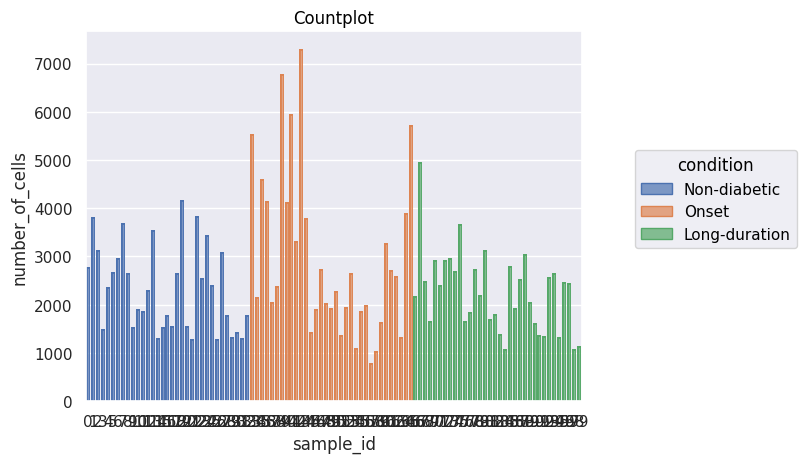

In [13]:
Analysis.plot_cell_counts()

In [54]:
Analysis.do_scaling("%quantile", 99)

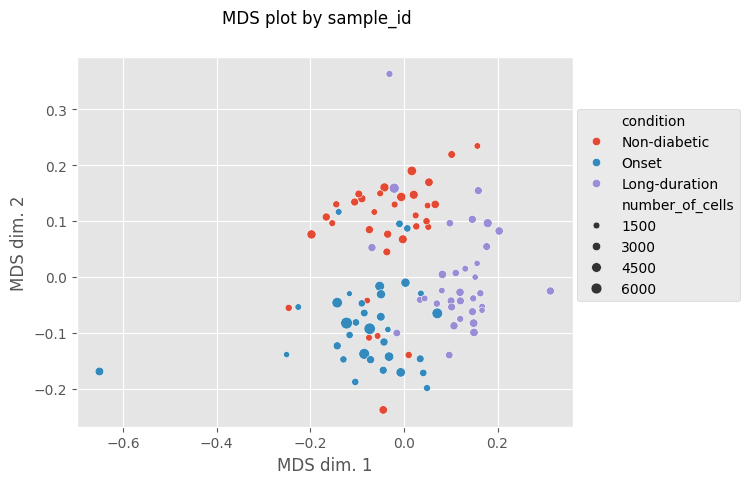

In [13]:
fig, mds_df = Analysis.plot_MDS(marker_class = 'type', color_by = 'condition')
fig

In [55]:
Analysis.do_flowsom(n_clusters = 20, rlen = 50, seed = 1234, scale_within_cells = True)
print(time.time() - start_timer)  ## keep track of time after each major step

2025-06-20 15:41:56.164 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-06-20 15:41:56.200 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-06-20 15:47:04.874 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


17005.806869506836


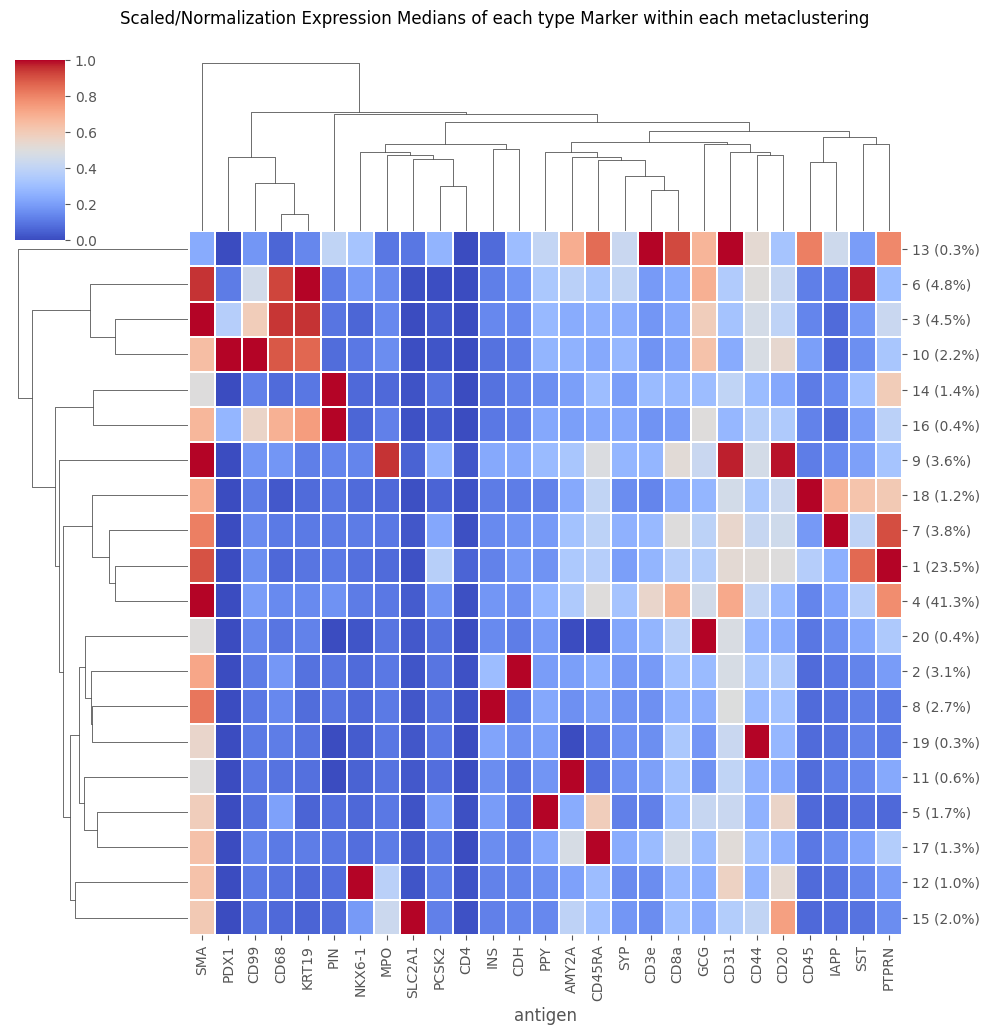

In [56]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'metaclustering')

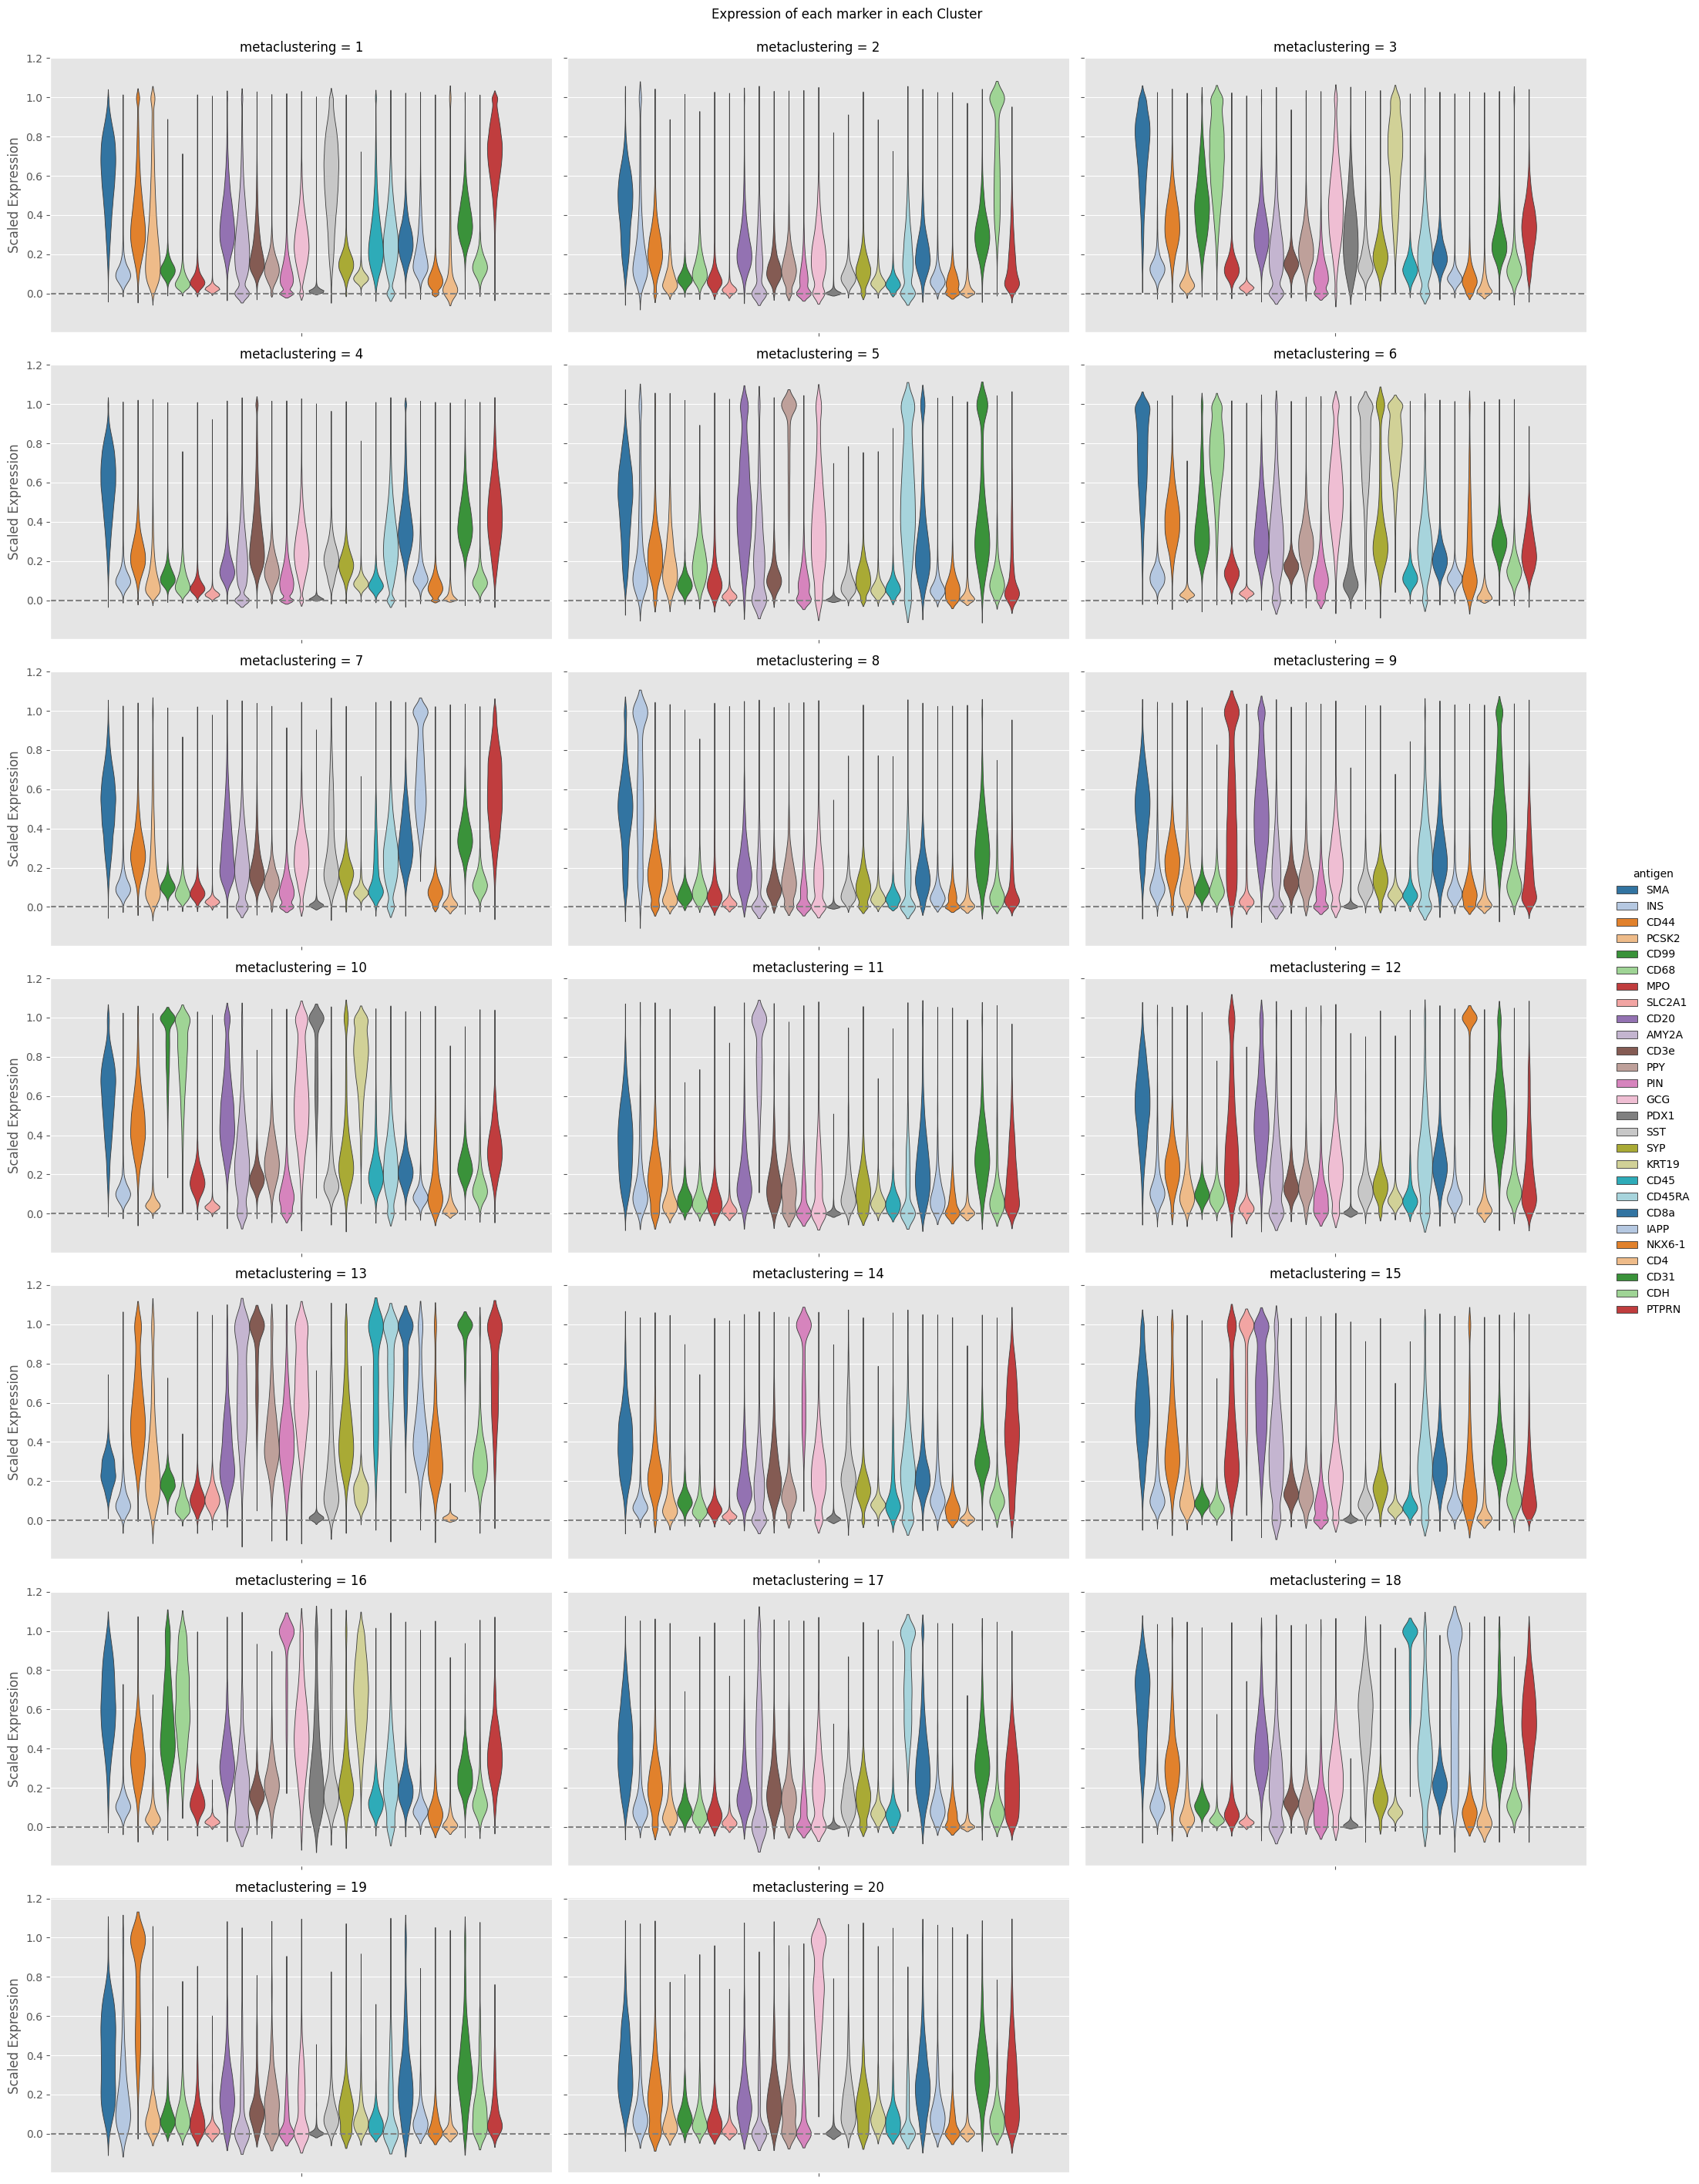

In [57]:
Analysis.plot_cluster_distributions(groupby_column = 'metaclustering', plot_type = 'violin')

In [9]:
Analysis.do_UMAP(marker_class = 'type', cell_number = 1000, seed = 42)
print(time.time() - start_timer) 

C:\Users\benca\miniforge3\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


671.219117641449


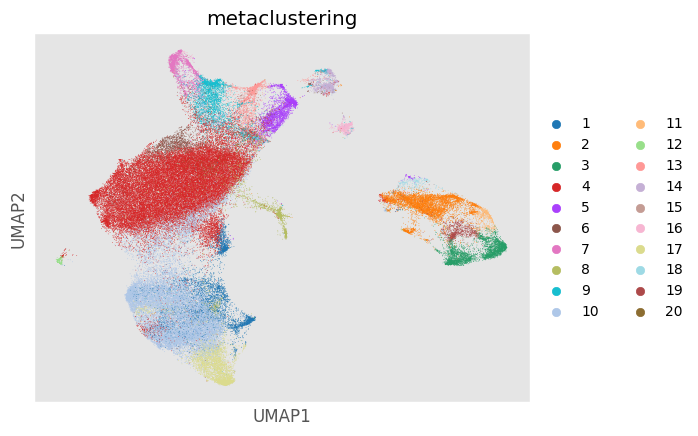

In [14]:
Analysis.plot_UMAP(color_by = 'metaclustering')

## Cell Type Annotation

Markers:

islet:

CD99, SYP, PDX1, PCSK2, PTPRN --> islet, (specific cell type preference?)

INS, IAPP, PIN, NKX6-1 --> beta cells

GCG --> alpha cells

SST --> delta cells

PPY --> gamma cells

vessel:

CD31, SMA --> blood vessel

exocrine:

CD44 --> exocrine

KRT19 --> ductal exocrine

AMY2A --> secretory exocrine (acinar)

immune:

CD45 --> immune lineage

CD45RA --> immune / naive

CD3 --> T cell

CD4 / CD8 --> helper / effector T cell

MPO --> neutrophil

CD68 --> monocyte lineage

CDH (e-cadherin) --> islet

CD20 --> B cell


For now, this will use only a portion of the data, as a test run. Since FlowSOM is a non-deterministic algorithm, this will need to be updated in the final version with all the data.

This example and soe of the subsequent plots are from an early attempt to annotate based on 20 metaclusters and 99.9% scaling, which have since changed as I see if I can get a better clustering of the data
with clearer / more biologically clean groups. 

Meta-cluster 1: PTPRN, IAPP ---> islet: beta

2: CD99, KRT19                                     ---> islet (beta cell ?)

3: PDX1, CDH                                       ---> islet: beta cell

4: CD4, CDH, SLC2A1                                ---> (?) CD-4 T cell (?)

5: CD31                                            ---> blood vessel (endothelium)

6: PPY++, PDX1, CD99, PCSK2, SYP, PTPRN, CDH       ---> islet: gamma cell

7: PDX1, PIN, IAPP, CD99, SYP, INS, PTPRN, NKX6-1  ---> islet: beta cell

8: CD31, SYP, CD99                                 ---> blood vessel or adjacent islet (?)

9: all low, highest = SMA, CDH, CD4                ---> unknown

10: CD20, CD45RA                                   ---> immune: B-cell

11: SST, SYP, CD99, PCSK2, PDX1                    ---> islet: delta cells

12: MPO, SLC2A1                                    ---> immune: neutrophil

13: CD3, CD45, CD8                                 ---> immune: effector T cell

14: SLC2A1, CD4, CD68                              ---> immune: monocyte / macrophage         (note: brightest cluster for CD68, even though CD68 is not very bright)

15: GCG, CD99, PCSK2, SYP, PTPRN, CDH              ---> islet: alpha cells

16: all low, highest = INS                         ---> unknown / beta cell (?)

17: CD3, CD45, CD4                                 ---> immune: helper T cell

18: CD45RA, CD4                                    ---> immune: naive lymphocyte

19: SMA                                            ---> blood vessel

20: CD3, CD4                                       ---> immune: T cell

In [38]:
## now annotate data
numbers = [str(i) for i in range(1,21,1)]
tissue_assignments = ["exocrine","islet","islet","unknown","vessel",
                      "islet","islet","vessel","unknown","immune",
                      "islet","immune","immune","immune","islet",
                      "unknown","immune","immune","vessel","immune"]
replacement_dict = dict(zip(numbers,tissue_assignments))
Analysis.data.obs['tissue_merging'] = Analysis.data.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 
Analysis.UMAP_embedding.obs['tissue_merging'] = Analysis.UMAP_embedding.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 
            ## the UMAP embedding is stored in a separate object from Analysis.data, because of downsampling

In [39]:
numbers = [str(i) for i in range(1,21,1)]
cell_assignments = ["exocrine","beta","beta","unknown","vessel",
                       "gamma","beta","vessel","unknown","B cell",
                      "delta","neutrophil","Tc","Monocyte","alpha",
                      "unknown","Th","naive T","vessel","Th"]
replacement_dict = dict(zip(numbers,cell_assignments))
Analysis.data.obs['cell_merging'] = Analysis.data.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 
Analysis.UMAP_embedding.obs['cell_merging'] = Analysis.UMAP_embedding.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 

In [12]:
Analysis.data.obs

,sample_id,file_name,patient_id,condition,clustering,metaclustering
0,0,C01_a0_full.fcs,Tail,Long-duration,90,13
1,0,C01_a0_full.fcs,Tail,Long-duration,71,11
2,0,C01_a0_full.fcs,Tail,Long-duration,93,13
3,0,C01_a0_full.fcs,Tail,Long-duration,23,7
4,0,C01_a0_full.fcs,Tail,Long-duration,0,30
...,...,...,...,...,...,...
874806,426,W39_a0_full.fcs,Head,Long-duration,20,23
874807,426,W39_a0_full.fcs,Head,Long-duration,28,8
874808,426,W39_a0_full.fcs,Head,Long-duration,0,30
874809,426,W39_a0_full.fcs,Head,Long-duration,89,10


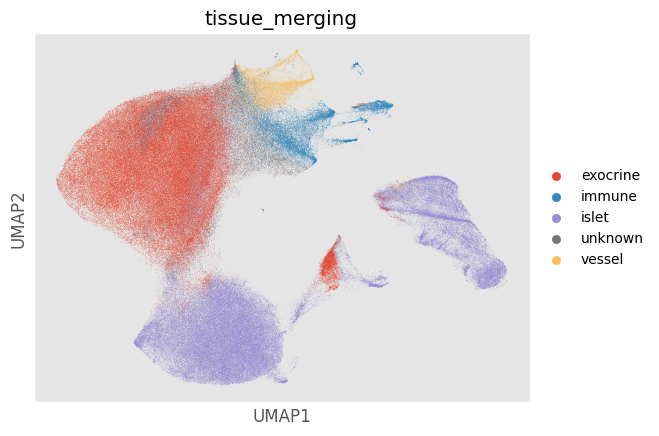

In [46]:
Analysis.plot_UMAP(color_by = 'tissue_merging')

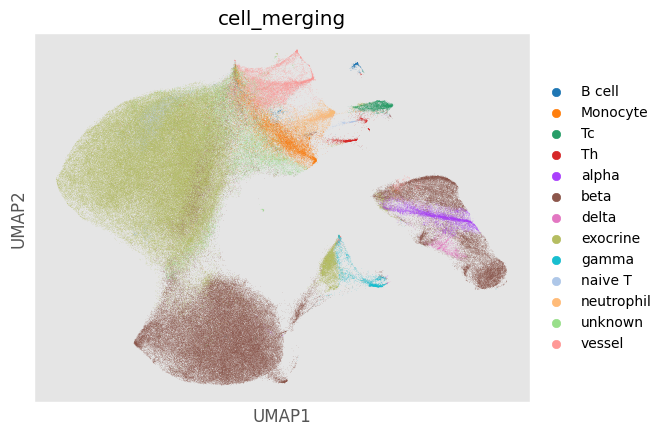

In [45]:
Analysis.plot_UMAP(color_by = 'cell_merging')

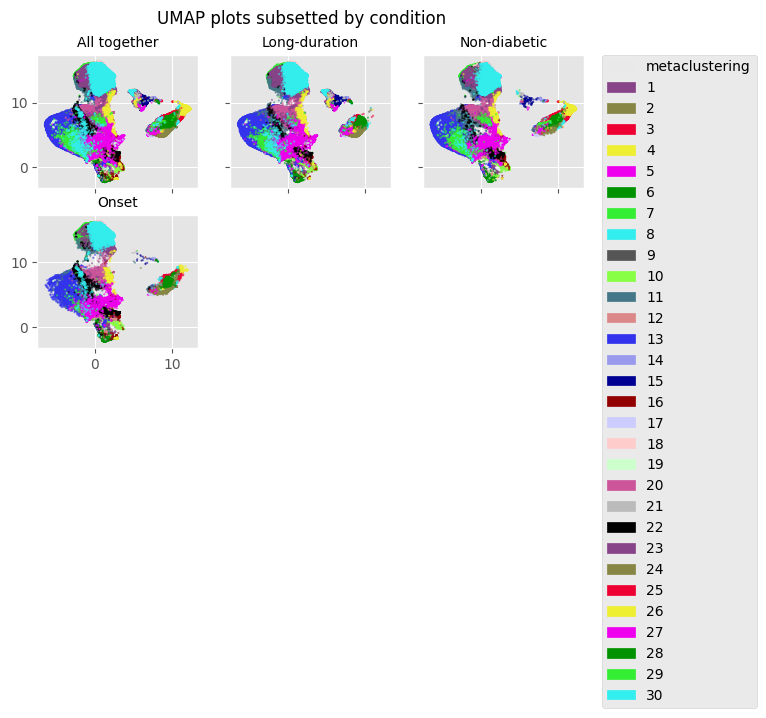

In [13]:
Analysis.plot_facetted_DR(color_by = 'metaclustering', kind = 'UMAP', subsetting_column = 'condition')

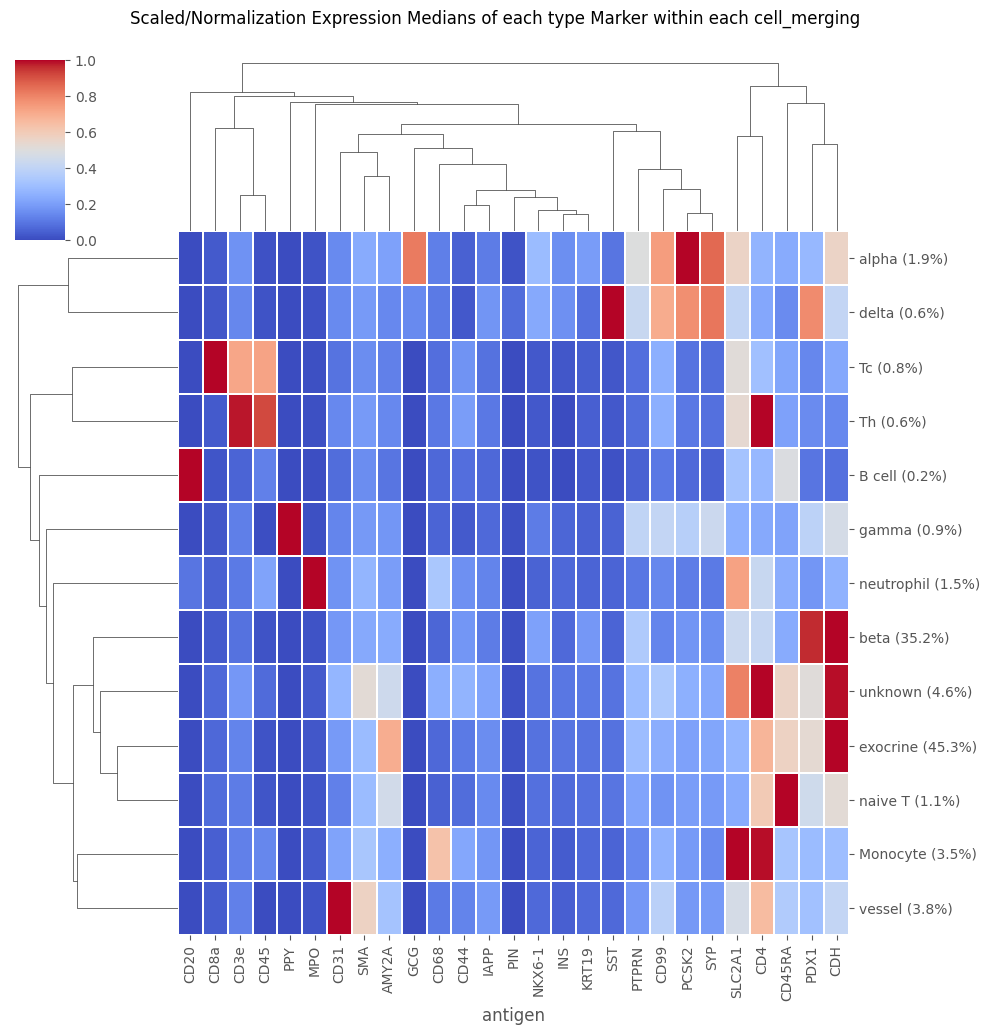

In [42]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'cell_merging')

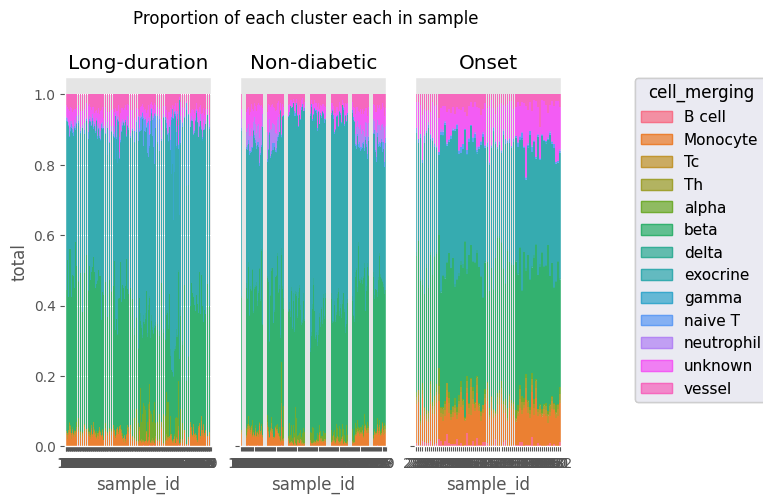

In [49]:
Analysis.plot_cluster_abundance_1(groupby_column = "cell_merging")

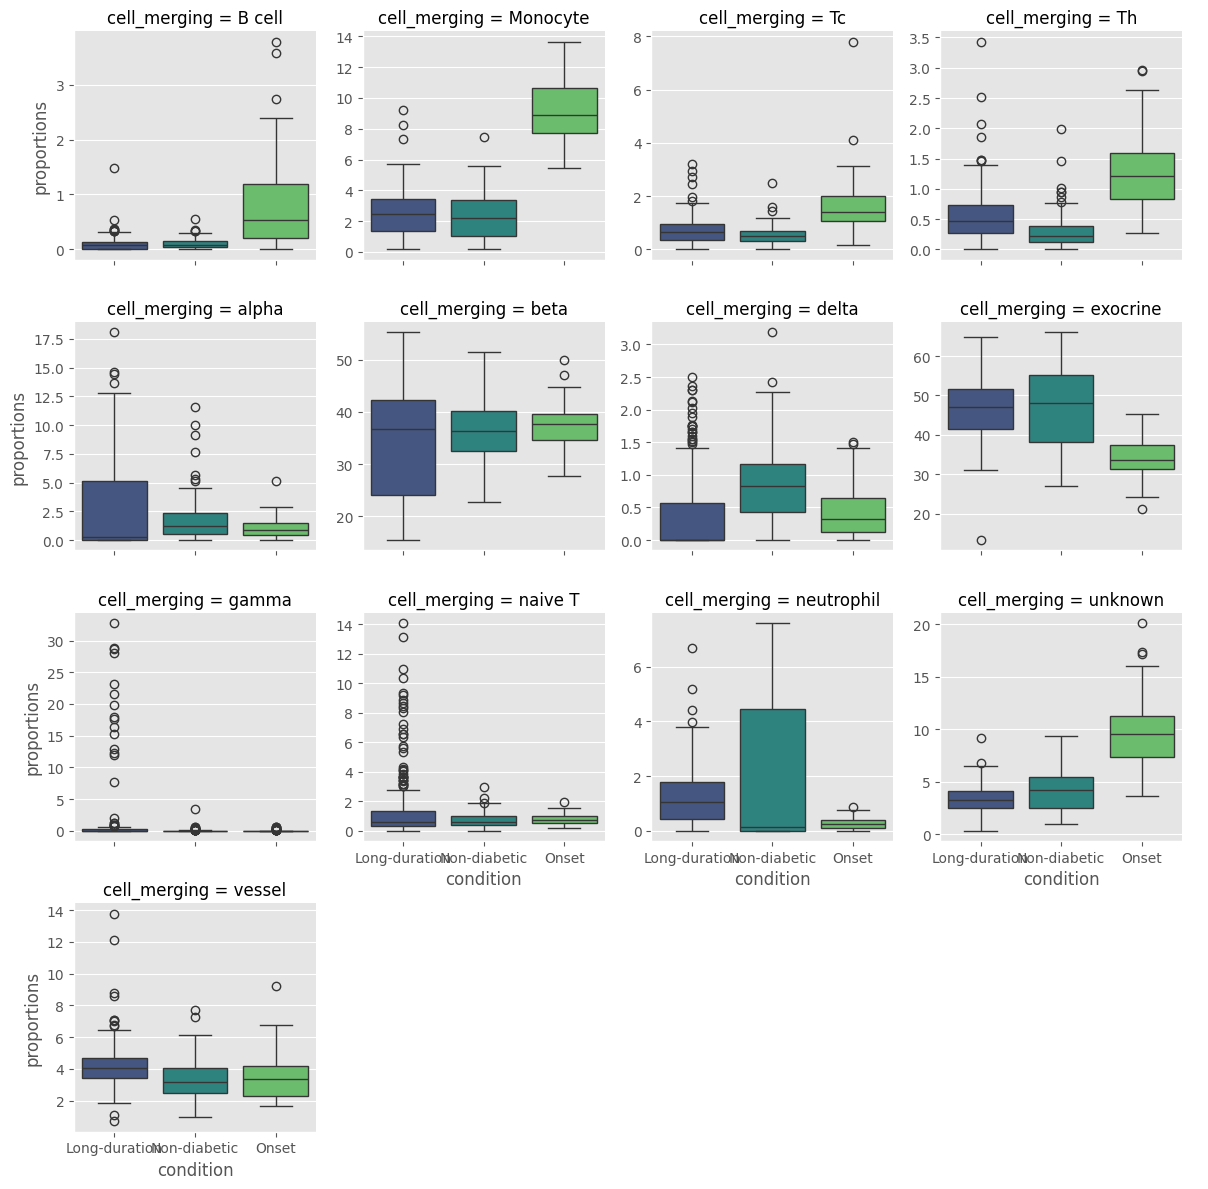

In [59]:
Analysis.plot_cluster_abundance_2(groupby_column = "cell_merging", hue = 'condition', plot_type = 'boxplot')

In [61]:
Analysis.do_count_GLM(variable = "condition", conditions = Analysis.data.obs['condition'].unique(), groupby_column = 'cell_merging', family = 'Poisson')

,comparison,cell_merging,pvalue,p_adj,Long-duration est. avg,Long-duration 95% CI +/-,Non-diabetic est. avg,Non-diabetic 95% CI +/-,Onset est. avg,Onset 95% CI +/-
11,Multiple Conditions,gamma,0.0,1.440000e-25,1.94,0.0222,0.0497,0.00387,0.0535,0.00618
3,Multiple Conditions,naive_T,1.22e-281,1.440000e-25,1.64,0.0205,0.692,0.0167,0.784,0.0254
5,Multiple Conditions,neutrophil,8.28e-171,1.440000e-25,1.28,0.0181,2.14,0.0392,0.288,0.0148
12,Multiple Conditions,delta,3.21e-145,1.440000e-25,0.384,0.0099,0.866,0.0274,0.375,0.0189
10,Multiple Conditions,alpha,1.23e-103,1.440000e-25,2.44,0.0249,1.7,0.0284,0.931,0.0273
4,Multiple Conditions,unknown,9.11e-71,1.440000e-25,3.32,0.0291,4.12,0.0502,9.45,0.116
7,Multiple Conditions,Th,4.09e-53,1.440000e-25,0.547,0.0118,0.306,0.0116,1.29,0.041
1,Multiple Conditions,beta,7.4e-46,1.440000e-25,34.0,0.093,35.9,0.142,36.9,0.19
2,Multiple Conditions,vessel,2.92e-37,1.440000e-25,4.14,0.0325,3.55,0.0427,3.48,0.0565
6,Multiple Conditions,Tc,8.68e-17,1.130000e-16,0.712,0.0135,0.556,0.0166,1.62,0.0456


In [10]:
## test pseudotime -- will really want to run this on islet segmentations
sc.pp.neighbors(Analysis.data)
sc.tl.diffmap(Analysis.data, n_branchings = 3)
print(time.time() - start_timer)  ## keep track of time after each major step

2083.706855535507


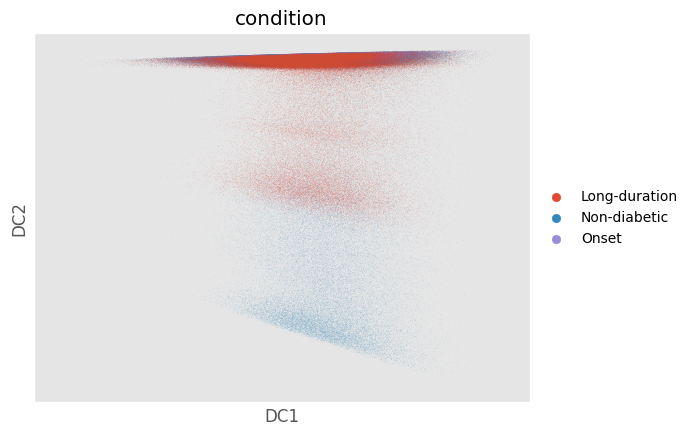

In [9]:
sc.pl.diffmap(Analysis.data, color = 'condition')